In [1]:
from unsloth import FastVisionModel

model, processor = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-unsloth-bnb-4bit",
    load_in_4bit=True,  # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing="unsloth",  # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


c:\Users\ryan\miniconda3\envs\unsloth\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\ryan\miniconda3\envs\unsloth\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:339: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.7.9: Fast Qwen2_5_Vl patching. Transformers: 4.53.3.
   \\   /|    NVIDIA GeForce RTX 4070 Laptop GPU. Num GPUs = 1. Max memory: 7.996 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [2]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,  # False if not finetuning vision layers
    finetune_language_layers=True,  # False if not finetuning language layers
    finetune_attention_modules=True,  # False if not finetuning attention layers
    finetune_mlp_modules=True,  # False if not finetuning MLP layers
    r=32,  # The larger, the higher the accuracy, but might overfit
    lora_alpha=32,  # Recommended alpha == r at least
    lora_dropout=0,
    bias="none",
    random_state=7043,
    use_rslora=False,  # We support rank stabilized LoRA
    loftq_config=None,  # And LoftQ
    target_modules="all-linear",  # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [3]:
# Load from disk use ONLY
from datasets import load_dataset

base_url = "../data_generation/dataset_s1_sm_disk/"
dataset = load_dataset(
    "arrow",
    data_files={
        "train": base_url + "train/data-00000-of-00001.arrow",
        "test": base_url + "test/data-00000-of-00001.arrow"
    },
    split="train"
)

In [4]:
# Load from hf_hub use ONLY

from datasets import load_dataset

dataset = load_dataset("Leppy-oss/ftc-lens-stage1-sm", split="train")

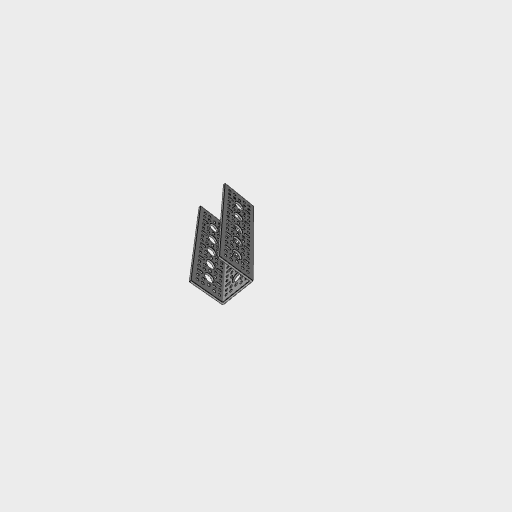

In [4]:
dataset[11]["image"]

In [5]:
dataset[11]["label"]

'UChannel5H'

In [6]:
instruction = "Identify the GoBilda part shown in this image without further elaboration."

def conversation_template(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["label"]}]},
    ]
    return {"messages": conversation}

converted_dataset = [conversation_template(sample) for sample in dataset]

In [7]:
FastVisionModel.for_inference(model)

image = dataset[2]["image"]

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=256,
    use_cache=True,
    temperature=1.0,
    top_p=0.95,
    top_k=64
)

The image shows aGoBilda (GoBild). This is likely a reference to GoBilda, which refers to both an Italian product and a computer font that was used extensively in software development for years.

- The first instance in the image represents a physical object, possibly referencing the 32mm GoBilda ruler often found in workshops.
- The second image indicates a digital or electronic representation, which would be interpreted as a text or display using the GoBilda font.
  
Given the current use of fonts in technology, the phrase "The GoBilda part" could denote:

1. **GoBilda Font Usage**: References the classic 6-point Futura font used by many software developers for coding purposes due to its clear and legible characters.
2. **GoBilda Ruler**: Refers to the standard GoBilda metric ruler, essential for measurement in technical fields such as architecture, engineering, and manufacturing.
3. **GoBilda Iconography**: Refers to a specific logo or icon used by GoBilda businesses (e.g., GoBilda 

In [7]:
import torch
from trl import SFTTrainer, SFTConfig
from unsloth.trainer import UnslothVisionDataCollator

FastVisionModel.for_training(model)  # Enable for training!
torch._dynamo.config.cache_size_limit = 32

trainer = SFTTrainer(
    model=model,
    tokenizer=processor,
    data_collator=UnslothVisionDataCollator(model, processor),  # Must use!
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        # max_steps=30,
        num_train_epochs=5,  # Set this instead of max_steps for full training runs
        learning_rate=2e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=7043,
        output_dir="outputs",
        report_to="none",  # For Weights and Biases
        # You MUST put the below items for vision finetuning:
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        max_seq_length=2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [9]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4070 Laptop GPU. Max memory = 7.996 GB.
3.992 GB of memory reserved.


In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 96 | Num Epochs = 5 | Total steps = 30
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 82,169,856 of 3,836,792,832 (2.14% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,8.138800
2,8.068400
3,7.914300
4,6.938800
5,5.423300
6,4.092100
7,3.219600
8,2.510500
9,1.919000
10,1.391500


In [11]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

954.0865 seconds used for training.
15.9 minutes used for training.
Peak reserved memory = 4.549 GB.
Peak reserved memory for training = 0.557 GB.
Peak reserved memory % of max memory = 56.891 %.
Peak reserved memory for training % of max memory = 6.966 %.


In [12]:
model.save_pretrained("fl_lora_s1_2d")  # Local saving
processor.save_pretrained("fl_lora_s1_2d")

[]

In [20]:
FastVisionModel.for_inference(model)

image = dataset[11]["image"]

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.0,
    top_p=0.95,
    top_k=64
)

UChannel4H<|im_end|>
